In [1]:
cd ..

/Users/cchivers/proj/chime_sims


In [18]:
import pandas as pd
from os import getcwd, path
from _99_shared_functions import *
import multiprocessing as mp
import matplotlib.pyplot as plt
from scipy import stats as sps

import sys
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

# Get parameters from files stored during step 1, don't get from args (one argument, directory)
sim_dir = '/Users/cchivers/proj/chime_sims/server_runs/04-14-20-all/'
datadir = path.join(f'{getcwd()}', 'data')
outdir = path.join(f'{getcwd()}', 'output')
figdir = path.join(f'{getcwd()}', 'figures')



hospital = 'Downtown'

census_ts = pd.read_csv(path.join(f"{datadir}",f"{hospital}_ts.csv"))
first_day = census_ts['date'].values[0]
params = pd.read_csv(path.join(f"{datadir}",f"{hospital}_parameters.csv"))
# impute vent with the proportion of hosp.  this is a crude hack
census_ts.loc[census_ts.vent.isna(), 'vent'] = census_ts.hosp.loc[census_ts.vent.isna()]*np.mean(census_ts.vent/census_ts.hosp)

# This needs to be configuable based on the time period specificed 
nobs = census_ts.shape[0]

# define capacity
vent_capacity = float(params.base.loc[params.param == 'vent_capacity'])
hosp_capacity = float(params.base.loc[params.param == 'hosp_capacity'])

# Chains
df = pd.read_pickle(path.join(f'{outdir}',f'{hospital}_chains.pkl'))

# remove burn-in
# Make 1000 configurable
df = df.loc[(df.iter>1000)] #& (~df.chain.isin([1, 12]))]

In [61]:
def plt_predictive(howfar=200, df = df):
    # predictive plot
    arrs = np.stack([df.arr.iloc[i] for i in range(df.shape[0])])
    arrq = np.quantile(arrs, axis = 0, q = [.05, .25, .5, .75, .95])

    dates = pd.date_range(f'{first_day}',
        periods=howfar, freq='d')
    fig, ax = plt.subplots(figsize=(16, 10), ncols=2, nrows=2, sharex=True)
    # hosp
    axx = ax[0,0]
    axx.plot_date(dates, arrq[2,:howfar,3], '-', label = 'posterior median')
    axx.set_ylabel(f'Hospital census', fontsize=12, fontweight='bold')
    #axx.set_xlabel(f'Days since {first_day}', fontsize=12, fontweight='bold')
    axx.fill_between(x = dates,
                       y1 = arrq[0,:howfar,3],
                       y2 = arrq[4,:howfar,3], 
                       label = '90% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k")
    axx.fill_between(x = dates,
                       y1 = arrq[1,:howfar,3],
                       y2 = arrq[3,:howfar,3], 
                       label = '50% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k")
#     axx.plot_date(dates[:census_ts.hosp.shape[0]], census_ts.hosp, '-',
#                color = "red",
#                label = "observed")
    axx.axhline(y=hosp_capacity, color='k', ls='--', label = "hospital capacity")
    axx.legend()
    axx.grid(True)

    axx = ax[0,1]
    axx.plot_date(dates, arrq[2,:howfar,5], '-', label = 'posterior median')
    axx.set_ylabel(f'Vent census', fontsize=12, fontweight='bold')
    #axx.set_xlabel(f'Days since {first_day}', fontsize=12, fontweight='bold')
    axx.fill_between(x = dates,
                       y1 = arrq[0,:howfar,5],
                       y2 = arrq[4,:howfar,5], 
                       label = '90% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k",)
    axx.fill_between(x = dates,
                       y1 = arrq[1,:howfar,5],
                       y2 = arrq[3,:howfar,5], 
                       label = '50% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k")
    axx.axhline(y=vent_capacity, color='k', ls='--', label = "vent capacity")
#     axx.plot_date(dates[:census_ts.vent.shape[0]], census_ts.vent, '-',
#                color = "red",
#                label = "observed")
    axx.legend()
    axx.grid(True)

    # Admits
    axx = ax[1,0]
    axx.plot_date(dates,arrq[2,:howfar,0], '-', label = 'posterior median')
    axx.set_ylabel(f'Hospital Admits', fontsize=12, fontweight='bold')
    #axx.set_xlabel(f'Days since {first_day}', fontsize=12, fontweight='bold')
    axx.fill_between(x = dates,
                       y1 = arrq[0,:howfar,0],
                       y2 = arrq[4,:howfar,0], 
                       label = '90% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k")
    axx.fill_between(x = dates,
                       y1 = arrq[1,:howfar,0],
                       y2 = arrq[3,:howfar,0], 
                       label = '50% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k")
    axx.legend()
    axx.grid(True)

    axx = ax[1,1]
    axx.plot_date(dates, arrq[2,:howfar,2], '-', label = 'posterior median')
    axx.set_ylabel(f'Vent Admits', fontsize=12, fontweight='bold')
    #axx.set_xlabel(f'Days since {first_day}', fontsize=12, fontweight='bold')
    axx.fill_between(x = dates,
                       y1 = arrq[0,:howfar,2],
                       y2 = arrq[4,:howfar,2], 
                       label = '90% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k",)
    axx.fill_between(x = dates,
                       y1 = arrq[1,:howfar,2],
                       y2 = arrq[3,:howfar,2], 
                       label = '50% Credible Region',
                       alpha = .1,
                       lw = 2,
                       edgecolor = "k")
    axx.legend()
    axx.grid(True)
    fig.autofmt_xdate()
    fig.tight_layout()

In [62]:
#plt_predictive(100, df = df)

In [104]:
df['reopen_day'] = 39 + 21 # begin reopening in 3 weeks
df['reopen_speed'] = 0.2

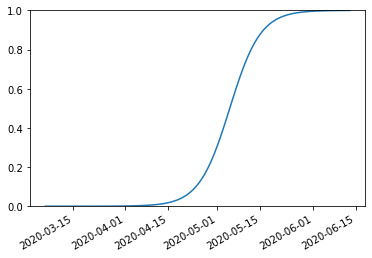

In [105]:
def reopenfn(day, half_way_to_baseline_day = 60, reopen_speed=0.1):
    return 1 - 1/(1+np.exp(-(reopen_speed*(day-half_way_to_baseline_day))))
    
howfar = 100
days = range(howfar)
dates = pd.date_range(f'{first_day}',
        periods=howfar, freq='d')
remove_sd = [1-reopenfn(day, df['reopen_day'].values[0], df['reopen_speed'].values[0]) for day in days]
fig, ax = plt.subplots(1,1)
ax.plot(dates, remove_sd)
ax.set_ylim(0,1)
fig.autofmt_xdate()

In [68]:
df.index = range(df.shape[0])
ddf = df.T.reset_index()

sims = []
idx_samples = np.random.choice([i for i in df.index], 500)
for param_col in idx_samples:
    p_df = ddf[['index', param_col]].rename(columns={'index': 'param', param_col: 'val'})
    sim = SIR_from_params(p_df)
    sims.append(sim)
df_reopen = pd.DataFrame(sims)

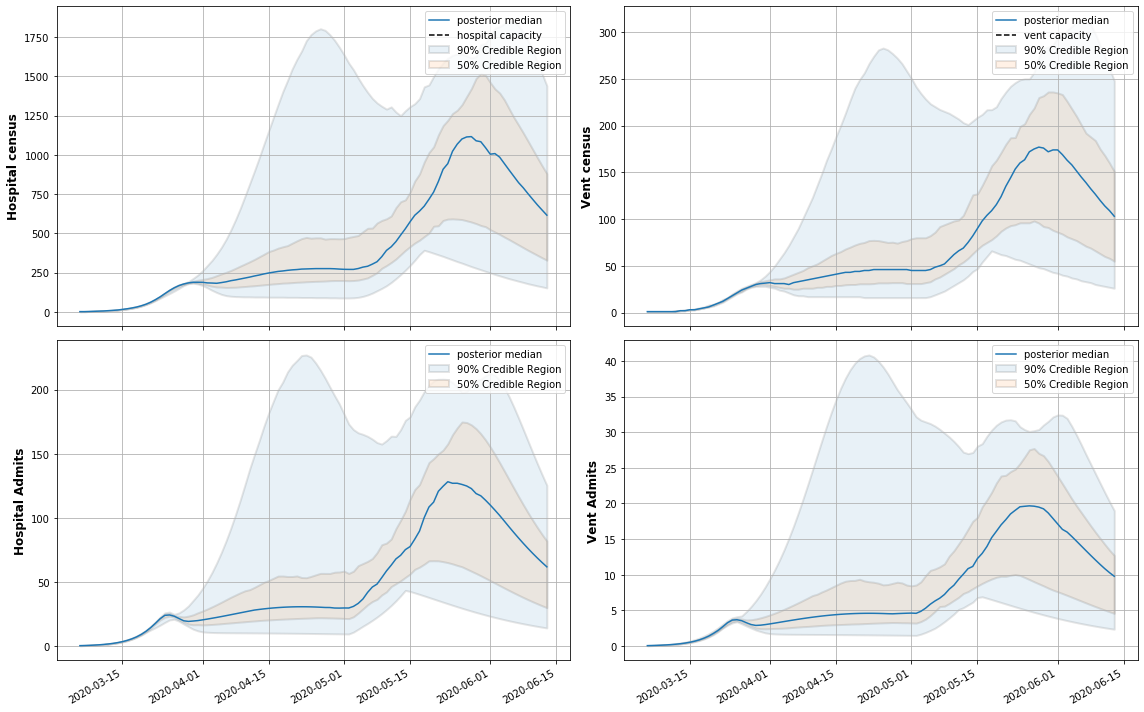

In [69]:
plt_predictive(100, df = df_reopen)